In [21]:
%run init_notebook.py

In [22]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format
from utils.plotting import *
from src.src import *

In [24]:
# Load data
model_type = "ols"
data_len = 8055 # 440, 660, 760, 1560
is_sent = False
week_day = 'daily'
predicted = "sp_close_lead1"

df_w = load_data(file_name=f"df_{week_day}_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_{week_day}_{data_len}.pkl", file_path=WORK_DATA_DIR)

if week_day == 'daily':
    assert is_sent is False, 'Treating non sentiment data'

In [25]:
data_dict["model_features"].update(predicted=predicted)
data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{data_dict['model_features']['predicted']}_sent{is_sent}")

# correlation

In [26]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    # 'vixo',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     # 'termspread',
     # 'pc_ratio',
     # 'fears35',
     # 'aaii_Bullish',
     # 'aaii_Bearish',
     # 'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     'sp_close_lag3',
     # 'sp_close_lag4',
     # 'sp_close_lag5',
     # 'sp_close_lag6',
     # 'sp_close_lag7',
]

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

In [27]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [28]:
df_cross_corr(df_ws,
              [item for item in cols if item not in data_dict["data"]["sp_cols"]] ,#+ ["sp_close"],
              data_dict["model_features"]["predicted"],
              show_plot=False,
             figsize=(5, 3))

[['ff_M_RF', 0, 0.083],
 ['ff_SMB', 0, 0.022],
 ['ff_HML', 0, 0.033],
 ['ff_RMW', 4, 0.032],
 ['ff_CMA', 10, 0.024]]

In [29]:
# df_ws, _ = shift_var_relative_to_df(df_ws,
#                                  shift_var=["aaii_Bullish"],
#                                  no_lags=[7])
# data_dict["data_transformation"].update(shift_var=_)
# df_ws = df_ws.dropna()

# Multicolinerarity

In [30]:
# # orthogonalise
df_ws = orthogonalise_vars(df_ws, X="sp_close", y="ff_M_RF", show_fig=False)
# df_ws = orthogonalise_vars(df_ws, X="sp_close", y="sp_close_lag1", show_fig=False)
# df_ws = orthogonalise_vars(df_ws, X="sp_close", y="sp_close_lag2", show_fig=False)
# df_ws = orthogonalise_vars(df_ws, X="sp_close_lag1", y="sp_close_lag2", show_fig=False)

,VIF,corr_sp_close_lead1
sp_close,1.231661,-0.087392
ff_HML,1.471100,-0.033180
sp_close_lag3,1.009336,-0.022348
sp_close_lag1,1.044894,-0.004405
ff_CMA,1.657456,-0.003133
sp_close_lag2,1.027201,0.000979
ff_SMB,2.396692,0.021967
ff_RMW,1.575871,0.026638
ff_M_RF,3.231778,0.029763


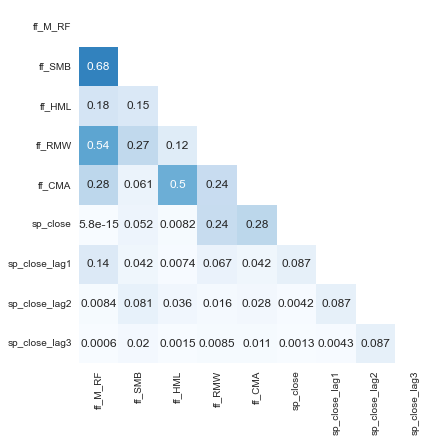

In [31]:
# only rely on correlation not vif
corr_heatmap(df_ws, 
             cols,
             # size_factor=1,
             show_fig=True)
get_variance_inflation_factor(df_ws, cols, col_pred=data_dict["model_features"]["predicted"])

# Regression

In [32]:
df_train = df_ws.copy()

In [33]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.2,
                                            add_const=False)

In [34]:
model = SKLearnWrap(sm.OLS, fit_intercept=True)
model_ = model.fit(X_train, y_train)

In [35]:
## Do variables need to be significant -> vixo signficance requires orthogonalisation

In [36]:
data_dict["model_metrics"].update(featuer_sig=model.results_.pvalues)
model.results_.pvalues < .05

ff_M_RF           True
ff_SMB           False
ff_HML           False
ff_RMW            True
ff_CMA           False
sp_close          True
sp_close_lag1     True
sp_close_lag2    False
sp_close_lag3    False
intercept         True
dtype: bool

In [37]:
model.results_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.077
Date:                Sat, 19 Mar 2022   Prob (F-statistic):           1.52e-08
Time:                        12:41:52   Log-Likelihood:                 19748.
No. Observations:                6444   AIC:                        -3.948e+04
Df Residuals:                    6434   BIC:                        -3.941e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
ff_M_RF           0.0049      0.002      2.706      0.007       0.001       0.008
ff_SMB           -0.0002      0.000     -0.648      0.517      -0.001       0.001
ff_HML           -0.0004      0.000     -1.310      0.190      -0.001       0.000
ff_RMW            0.0011      0.000      2.811      0.005       0.000       0.002
ff_CMA           -0.0001      0.000     -0.274      0.784      -0.001       0.001
sp_close         -0.0474      0.014     -3.310      0.001      -0.076      -0.019
sp_close_lag1    -0.0517      0.013     -4.062      0.000      -0.077      -0.027
sp_close_lag2     0.0012      0.013      0.094      0.925      -0.023       0.026
sp_close_lag3    -0.0088      0.012     -0.706      0.480      -0.033       0.016
intercept         0.0003      0.000      2.171      0.030    2.98e-05       0.001
==============================================================================
Omnibus:                     1141.453   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18685.330
Skew:                          -0.355   Prob(JB):                         0.00
Kurtosis:                      11.312   Cond. No.                         103.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

''

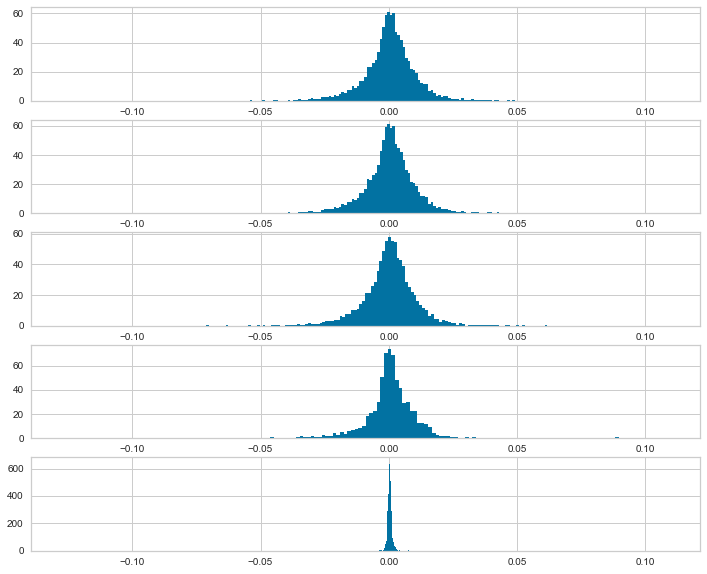

In [38]:
fig, ax = plt.subplots(5, 1, figsize=(12, 10))
ax[0].hist(df_train.sp_close_lead1, bins='fd', density=True)
ax[1].hist(df_w.sp_close_lead1, bins='fd', density=True)
ax[2].hist(y_train, bins='fd', density=True)
ax[3].hist(y_test, bins='fd', density=True)
ax[4].hist(model_.predict(X_test), bins='fd', density=True)

ax[2].set_xlim(ax[0].get_xlim())
ax[3].set_xlim(ax[0].get_xlim())
ax[4].set_xlim(ax[0].get_xlim())
;

# Out of sample eval

In [39]:
# benchmark: mittelwert prognose - das ist ein random walk mit drift

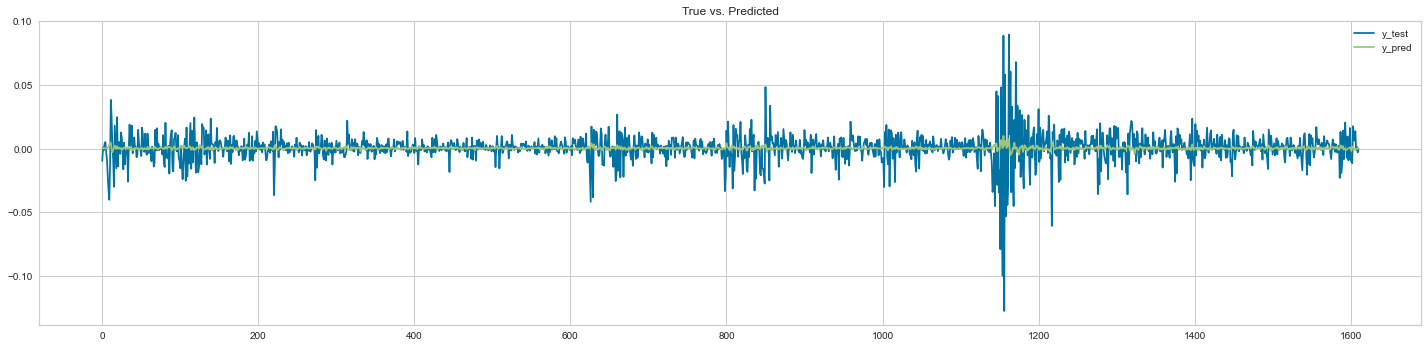

Validation Scores
root mean squared error: 0.0116275831
mean squared error: 0.0001352007
mean absolute error: 0.0070545663
R2: 0.0059896886


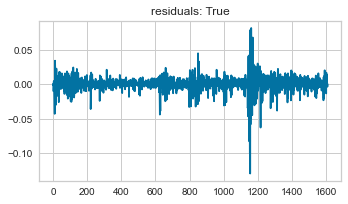

Stationarity Test Results
P-Values: 1.0760647894714107e-22
Test-stats: -12.226769990501328
Time series is stationary: True


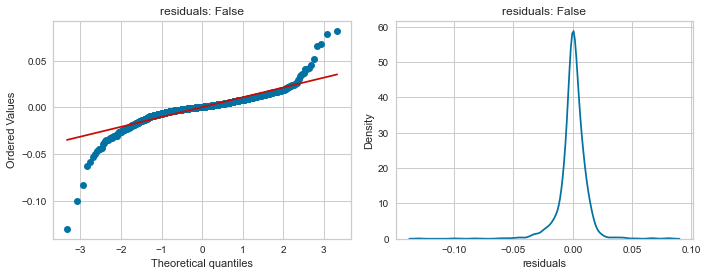

Normality Test Results
P-Values: 1.22854436413571e-156
Test-stats: 717.994888964603
Series is normally distributed: False
HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


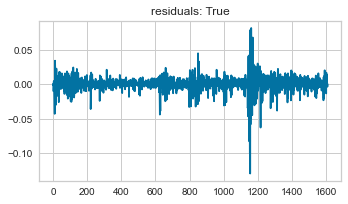

Test for Heteroskedasticity
Test p-value: 1.37374474757159e-214
Heteroskedasticity is present: True


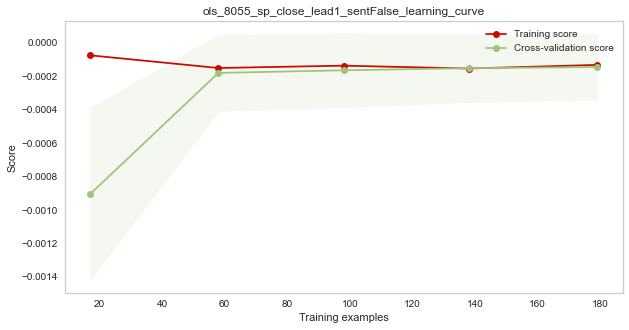

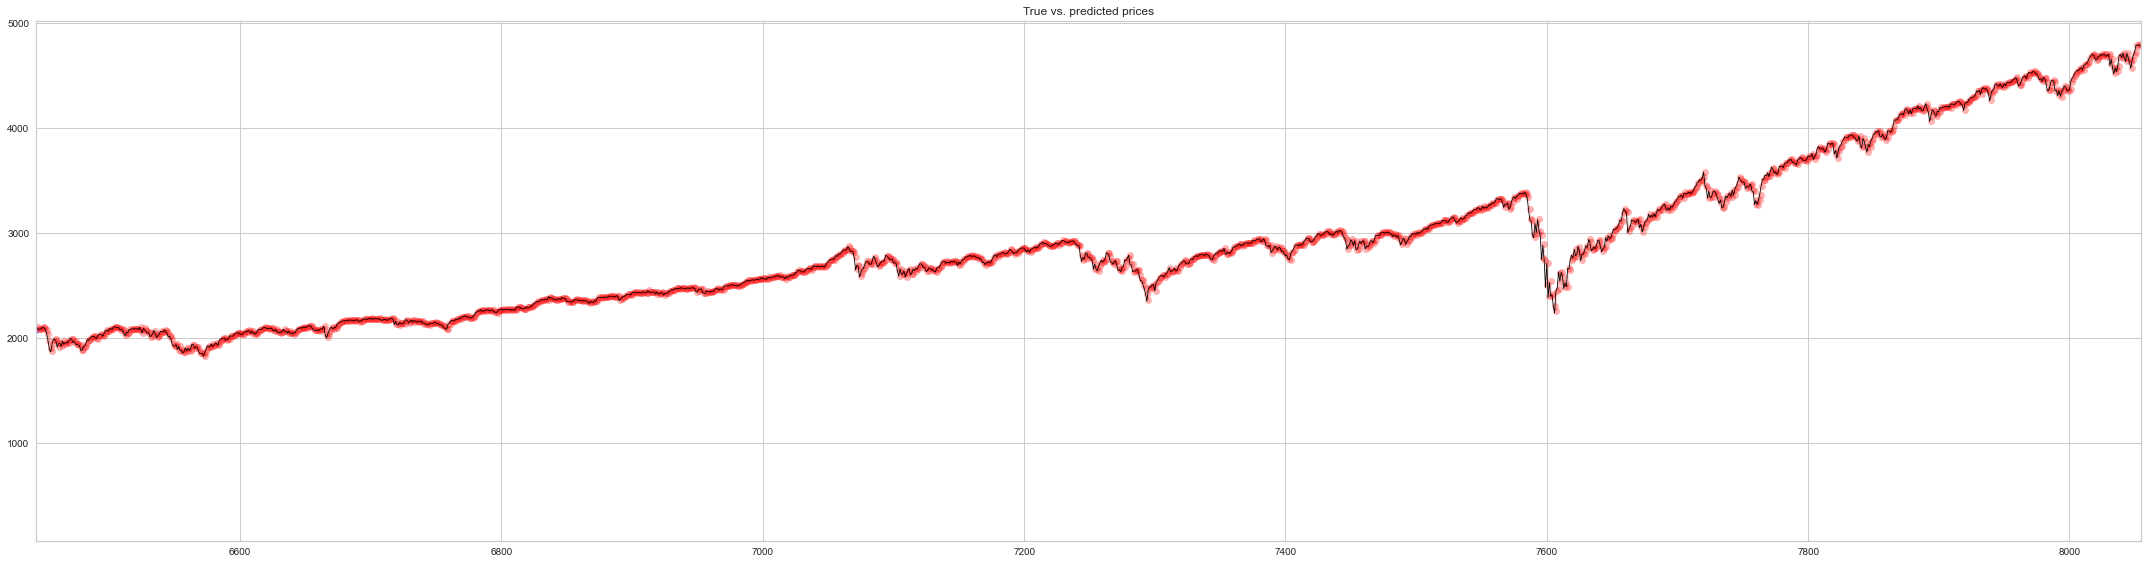

Validation Scores Test Data
mean squared error: 1074.2690872861
mean absolute error: 20.256149368
mean absolute error in %: 0.014239073843440185
r2: 0.9979770129


In [40]:
mval = ModelValidation(
            X_train=X_train,
            y_train=y_train,
            X_validate=X_test,
            y_validate=y_test,
            model=model,
            print_results=True)

fig_true_vs_fit = mval.get_model_performance()
stat, norm, hetero = mval.analyse_resids()

fig_lcurve = mval.sm_learning_curve(f"{data_dict['model_metrics']['model_name']}_learning_curve", n_splits=8)
fig_prices = mval.plot_results_on_price_scale(df_w,
                                              df_ws,
                                              sp_true_vals=data_dict["data"]["sp_true_vals"], show_pred_only=True)

# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)

# model performance
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid_inv)

# Save model

In [41]:
save_model(model, df_train, data_dict, fig_true_vs_fit, fig_lcurve, fig_prices, OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-19_ols_8055_sp_close_lead1_sentFalse"? (y/n)


 y
